In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from keras.models import Model
from sklearn.model_selection import train_test_split

# Create dataframe

In [2]:
ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size224_cleaned/UShape"
no_ushapes = r"G:/My Drive/HARP_DATASET/dataset_supervised/square_images_size224_cleaned/NoUshape"

In [3]:
def extract_spectrograms(path):
  os.chdir(path)
  spectrograms = []

  with os.scandir(path) as files:
    for file in files:
      if file.name.endswith('.png'):
        spectrograms.append(file.path)
  return spectrograms

ushapes_spectrograms = extract_spectrograms(ushapes)
all_spectrograms = extract_spectrograms(no_ushapes)

print(len(ushapes_spectrograms), len(all_spectrograms))
no_ushape_spectrograms = [spectrogram_without_ushape for spectrogram_without_ushape in all_spectrograms if spectrogram_without_ushape not in ushapes_spectrograms]

168 3822


In [4]:
def fill_df_with_label(spectrograms, label):
  new_df =  pd.DataFrame()
  new_df['filename'] = spectrograms
  new_df['label'] = [label] * len(spectrograms)

  return new_df


dataframe_total = fill_df_with_label(ushapes_spectrograms, "ushape").append(fill_df_with_label(no_ushape_spectrograms, "noshape"))


df_train, df_rest = train_test_split(dataframe_total, random_state = 101, test_size=0.25)
df_val, df_eval = train_test_split(df_rest, random_state = 101, test_size=0.50)

In [5]:
print(df_val)

                                               filename    label
2292  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
2164  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1575  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1342  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1749  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
...                                                 ...      ...
605   G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
50    G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
646   G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
35    G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape
1869  G:/My Drive/HARP_DATASET/dataset_supervised/sq...  noshape

[499 rows x 2 columns]


In [5]:
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(224, 224, 3),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(224, 224, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
print(df_val)

                                               filename    label
2292  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
2164  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1575  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1342  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1749  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
...                                                 ...      ...
605   /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
50    /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
646   /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
35    /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape
1869  /content/drive/MyDrive/HARP_DATASET/dataset_su...  noshape

[499 rows x 2 columns]


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 

# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    # directory='harp/training/',
    x_col='filename',
    y_col='label',
    class_mode='binary',

    
    target_size=(224, 224),
)

val_generator = train_datagen.flow_from_dataframe(
    df_val,
    # directory='harp/validation/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(224, 224),
)

Found 2992 validated image filenames belonging to 2 classes.
Found 499 validated image filenames belonging to 2 classes.


In [7]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator)

c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1864: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
c:\y\HARP_3_7\venv\lib\site-packages\keras\preprocessing\image.py:1874: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


Epoch 1/50
94/94 [==============================] - 530s 6s/step - loss: 0.1715 - accuracy: 0.9589 - val_loss: 0.1485 - val_accuracy: 0.9499
Epoch 2/50
94/94 [==============================] - 435s 5s/step - loss: 0.1311 - accuracy: 0.9599 - val_loss: 0.1411 - val_accuracy: 0.9499
Epoch 3/50
94/94 [==============================] - 568s 6s/step - loss: 0.1242 - accuracy: 0.9612 - val_loss: 0.1347 - val_accuracy: 0.9519
Epoch 4/50
94/94 [==============================] - 459s 5s/step - loss: 0.1207 - accuracy: 0.9619 - val_loss: 0.1336 - val_accuracy: 0.9519
Epoch 5/50
94/94 [==============================] - 491s 5s/step - loss: 0.1142 - accuracy: 0.9602 - val_loss: 0.1229 - val_accuracy: 0.9559
Epoch 6/50
94/94 [==============================] - 496s 5s/step - loss: 0.1142 - accuracy: 0.9646 - val_loss: 0.1255 - val_accuracy: 0.9539
Epoch 7/50
94/94 [==============================] - 500s 5s/step - loss: 0.1139 - accuracy: 0.9626 - val_loss: 0.1179 - val_accuracy: 0.9539
Epoch 8/50
94

In [8]:
model.save('./harp_transfer_resnet_more_50epochs')

INFO:tensorflow:Assets written to: ./harp_transfer_resnet_more_50epochs\assets


INFO:tensorflow:Assets written to: ./harp_transfer_resnet_more_50epochs\assets


1/1 [==============================] - 0s 220ms/step


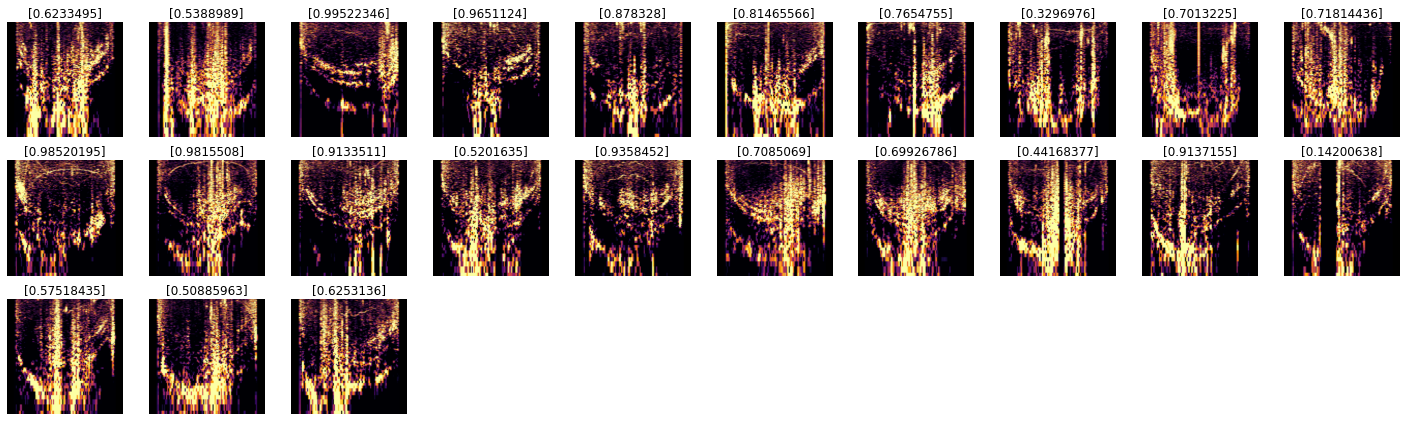

In [ ]:
y_true = df_eval.loc[df_eval['label'] == 'noshape'] 
y_pred = []
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))

index = 1
for image_to_predict in df_eval["filename"]:
    img = tf.keras.utils.load_img(
        ushapes + '/' + image_to_predict, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    ax = plt.subplot(10,10, index)
    ax.set_title(str(predictions[0]))
    plt.imshow(img)
    plt.axis('off')


    plt.imshow(img_array[0].numpy().astype("uint8"))
    index += 1


1/1 [==============================] - 0s 214ms/step


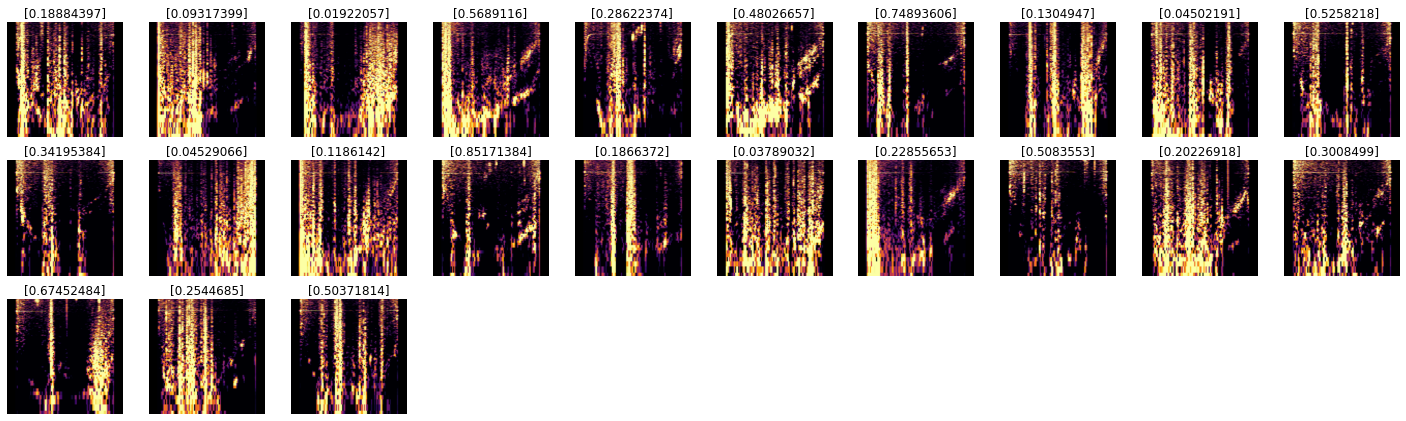

In [ ]:
y_true = df_eval.loc[df_eval['label'] == 'ushape'] 
y_pred = []
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 25))

index = 1
for image_to_predict in df_eval["filename"]:
    img = tf.keras.utils.load_img(
        ushapes + '/' + image_to_predict, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    ax = plt.subplot(10,10, index)
    ax.set_title(str(predictions[0]))
    plt.imshow(img)
    plt.axis('off')


    plt.imshow(img_array[0].numpy().astype("uint8"))
    index += 1

In [ ]:
def predcit_image(file_to_test):
  img = tf.keras.utils.load_img(
          file_to_test, target_size=(224, 224)
      )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)


  plt.axis('off')

  plt.imshow(img_array[0].numpy().astype("uint8"))

  print(predictions[0])



In [ ]:
file_to_test = no_ushapes + "/THE_stft_20170206_20170207_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 0s 481ms/step
[0.46708164]


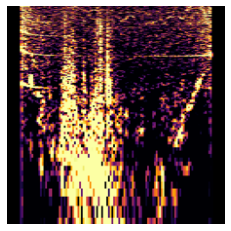

In [ ]:
file_to_test = no_ushapes + "/THE_stft_20170524_20170525_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 1s 626ms/step
[0.00063809]


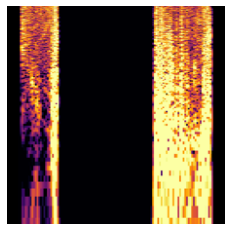

In [ ]:
file_to_test = no_ushapes + "/THE_stft_20170615_20170617_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 0s 470ms/step
[0.00063809]


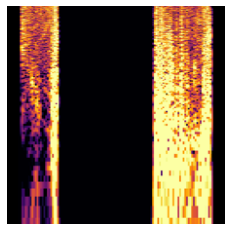

In [ ]:

file_to_test = no_ushapes + "/THE_stft_20170615_20170617_dynamic.png"
predcit_image(file_to_test)

1/1 [==============================] - 1s 572ms/step
[0.38730907]


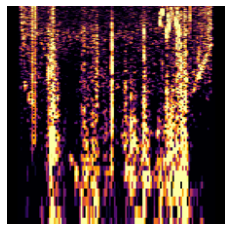

In [ ]:
file_to_test = no_ushapes + "/THE_stft_20190203_20190204_dynamic.png"
predcit_image(file_to_test)

In [ ]:
print(model.history.history)

{}


In [10]:
import matplotlib.pyplot as plt

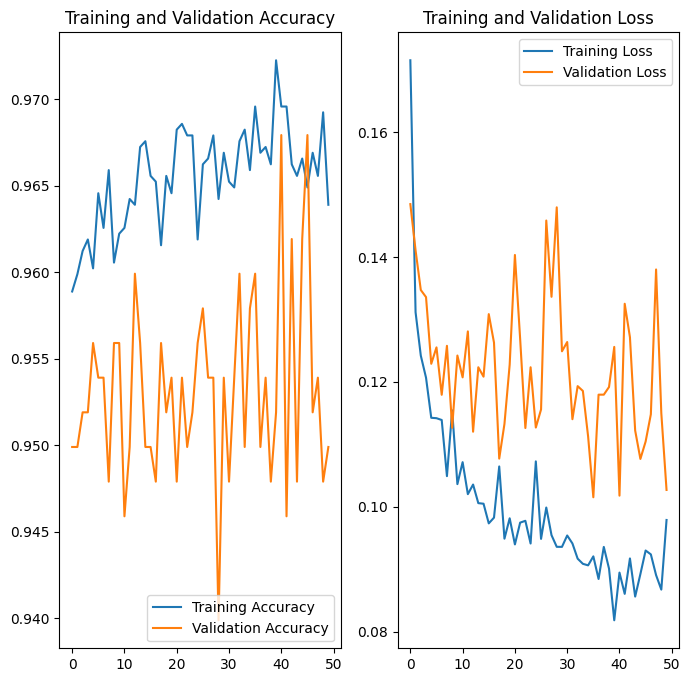

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
from sklearn import metrics
y_predicted_values = []

accuracies = []

for filename in df_eval["filename"]:
    img = tf.keras.utils.load_img(
    filename, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) 

    predictions = model.predict(img_array)

    accuracies.append(predictions)

    if predictions > 0.5:
        y_predicted_values.append("ushape")
    else:
        y_predicted_values.append("noshape")

df_eval["predicted"] = y_predicted_values
df_eval["accuracy"] = accuracies


1/1 [==============================] - 0s 51ms/step


In [25]:
y_true = [int(value is 'ushape') for value in df_eval['label']]
y_predict = [int(value is not 'noshape') for value in df_eval['predicted']]


print(metrics.classification_report(y_true=y_true, y_pred=y_predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       483
           1       0.36      0.25      0.30        16

    accuracy                           0.96       499
   macro avg       0.67      0.62      0.64       499
weighted avg       0.96      0.96      0.96       499



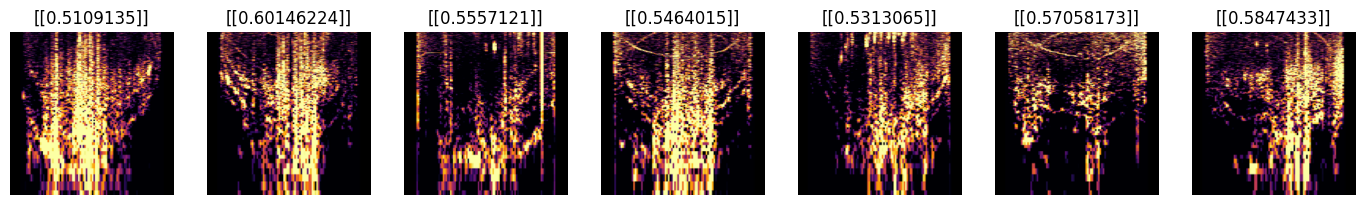

In [26]:
false_true = df_eval.loc[(df_eval['predicted'] == 'ushape') & (df_eval['label'] == "noshape")] 
plt.figure(figsize=(25, 25))

index = 1
for image, accuracy in zip(false_true['filename'],false_true['accuracy']):
    img = tf.keras.utils.load_img(
        image, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    ax = plt.subplot(10,10, index)
    ax.set_title(str(accuracy))
    plt.imshow(img)
    plt.axis('off')
    plt.imshow(img_array[0].numpy().astype("uint8"))
    index += 1


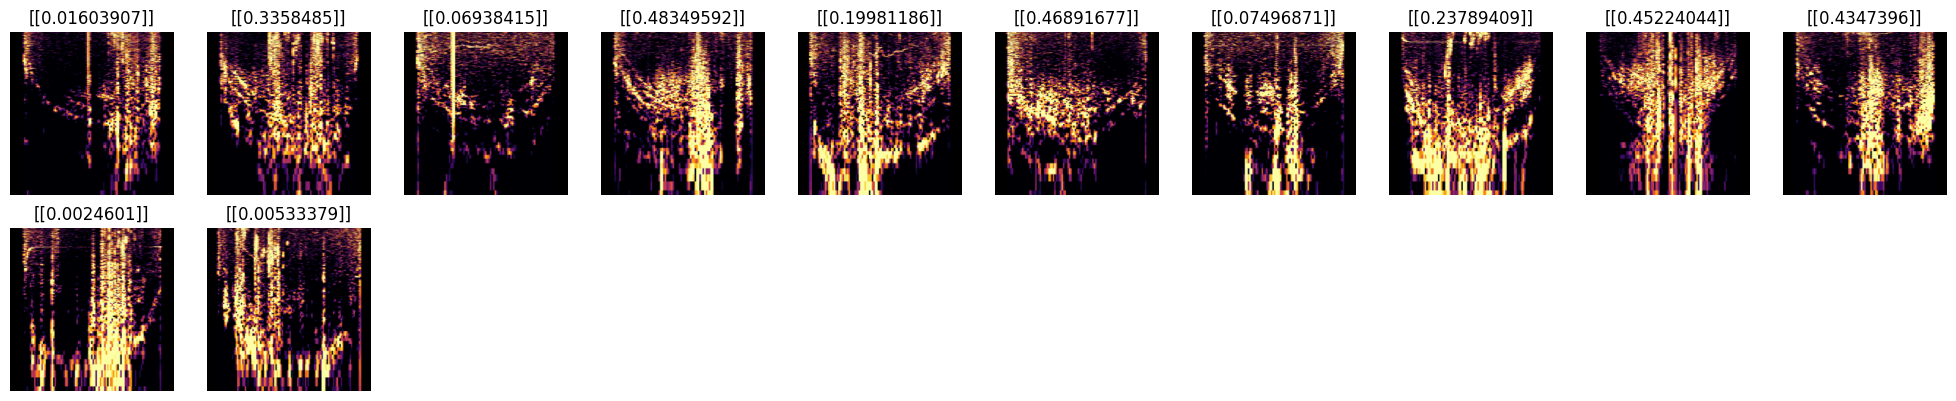

In [27]:
false_true = df_eval.loc[(df_eval['predicted'] == 'noshape') & (df_eval['label'] == "ushape")] 
plt.figure(figsize=(25, 25))

index = 1
for image, accuracy in zip(false_true['filename'],false_true['accuracy']):
    img = tf.keras.utils.load_img(
        image, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    ax = plt.subplot(10,10, index)
    ax.set_title(str(accuracy))
    plt.imshow(img)
    plt.axis('off')
    plt.imshow(img_array[0].numpy().astype("uint8"))
    index += 1

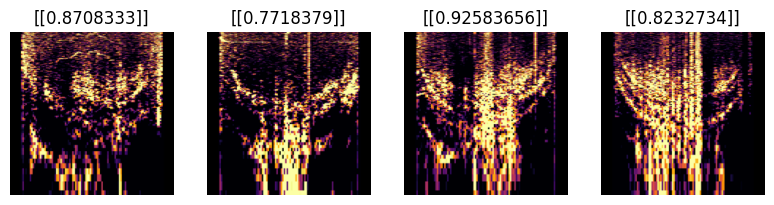

In [28]:
false_true = df_eval.loc[(df_eval['predicted'] == 'ushape') & (df_eval['label'] == "ushape")] 
plt.figure(figsize=(25, 25))

index = 1
for image, accuracy in zip(false_true['filename'],false_true['accuracy']):
    img = tf.keras.utils.load_img(
        image, target_size=(224, 224)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    ax = plt.subplot(10,10, index)
    ax.set_title(str(accuracy))
    plt.imshow(img)
    plt.axis('off')
    plt.imshow(img_array[0].numpy().astype("uint8"))
    index += 1